# Llamar librerias 

In [1]:
%pip install opencv-python matplotlib numpy scipy tqdm scikit-learn Rtree faiss-cpu scikit-image

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm
import sklearn  
import rtree
import faiss 
import os
from skimage import color , io

# Cargar data de features locales 

In [3]:
directory_path = directory_path = os.path.join("F:/", "DB2_Proyect", "portraits") 
features_path = os.getcwd()
index = 'data/index_dict_color_cv.npz'
vector = 'data/feature_vector_color_cv.npy'
data_dict = np.load(os.path.join(features_path,index), allow_pickle=True)
index_dict = data_dict['arr_0'].item()  # .item() para convertir a diccionario
# Cargar el array desde el archivo .npy
feature_vector = np.load(os.path.join(features_path,vector))

images_names = os.listdir(directory_path)


10085920.jpg


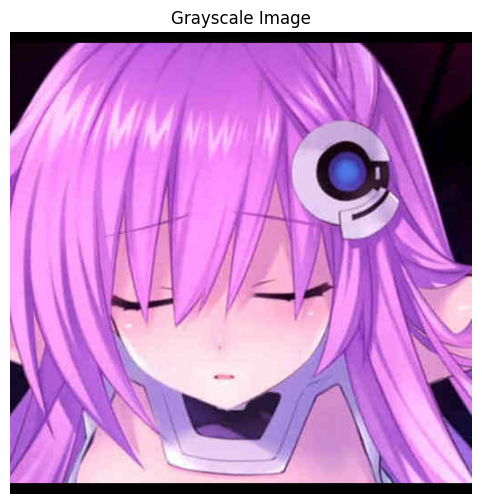

In [4]:

# Ruta de la imagen
image_index = 543
image_path = os.path.join(directory_path, images_names[image_index])

# Cargar la imagen y convertirla a escala de grises
image = io.imread(image_path)


# Mostrar la imagen en escala de grises
print(images_names[image_index])
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

# Graficadora de resultados 

In [5]:
def display_images_in_grid(image_paths, grid_rows, grid_cols):
    """
    Muestra las imágenes en una cuadrícula de subplots con el nombre de la imagen como título.

    Parameters:
    image_paths (list): Lista de rutas de imágenes a mostrar.
    grid_rows (int): Número de filas en la cuadrícula.
    grid_cols (int): Número de columnas en la cuadrícula.
    """
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2))
    
    # Aplanar el arreglo de ejes para fácil iteración
    axes = axes.flatten()
    
    # Mostrar cada imagen en su posición correspondiente
    for i, image_path in enumerate(image_paths):
        
        if i < len(axes):  # Para evitar errores si hay más espacios que imágenes
            image = io.imread(image_path)
            
            # Determinar si la imagen es en escala de grises o a color
            if image.ndim == 2:
                # Escala de grises
                axes[i].imshow(image, cmap='gray')
            elif image.ndim == 3:
                # A color (RGB)
                axes[i].imshow(image)
            else:
                raise ValueError(f"La imagen {image_path} tiene un formato inesperado: {image.ndim} dimensiones.")
            
            # Extraer solo el nombre del archivo
            image_name = os.path.basename(image_path)
            
            # Establecer el título con el nombre de la imagen
            axes[i].set_title(image_name)
            axes[i].axis('off')
    
    # Desactivar cualquier subplot vacío
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


# Generador de Query

In [6]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(cell_image, P=8, R=1, method='uniform', bins=4):
    lbp_features = []
    for channel in range(3):  # RGB
        lbp = local_binary_pattern(cell_image[:, :, channel], P=P, R=R, method=method)
        # Calcular histograma
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        # Normalizar
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.extend(hist)
    return np.array(lbp_features)  # 3 canales * 4 bins = 12

def extract_color_histogram(cell_image, bins=4):
    color_hist = []
    for channel in range(3):  # RGB
        hist, _ = np.histogram(cell_image[:, :, channel], bins=bins, range=(0, 256))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        color_hist.extend(hist)
    return np.array(color_hist)  # 3 canales * 4 bins = 12

def extract_hog_features_opencv(gray_cell, orientations=4, pixels_per_cell=(64, 64), cells_per_block=(1, 1)):
    winSize = (gray_cell.shape[1] // pixels_per_cell[1] * pixels_per_cell[1],
               gray_cell.shape[0] // pixels_per_cell[0] * pixels_per_cell[0])
    hog = cv2.HOGDescriptor(_winSize=winSize,
                            _blockSize=(pixels_per_cell[1]*cells_per_block[1],
                                        pixels_per_cell[0]*cells_per_block[0]),
                            _blockStride=(pixels_per_cell[1], pixels_per_cell[0]),
                            _cellSize=pixels_per_cell,
                            _nbins=orientations)
    hog_features = hog.compute(gray_cell)
    hog_features = hog_features.flatten()
    # Reducir a 4 dimensiones si es necesario
    if len(hog_features) > orientations:
        hog_features = np.mean(hog_features.reshape(-1, orientations), axis=0)
    elif len(hog_features) < orientations:
        hog_features = np.pad(hog_features, (0, orientations - len(hog_features)), 'constant')
    return hog_features

def process_image_opencv(image_path, orientations=4, pixels_per_cell=(64, 64), cells_per_block=(1, 1), 
                        P=8, R=1, lbp_bins=4, color_bins=4):
    image = io.imread(image_path)
    
    # Validar que la imagen sea RGB
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError(f"La imagen {image_path} no es RGB o no tiene 3 canales.")
    
    # Validar tamaño de la imagen (512x512)
    if image.shape[0] != 512 or image.shape[1] != 512:
        raise ValueError(f"La imagen {image_path} no tiene tamaño 512x512. Tamaño actual: {image.shape[:2]}")
    
    # Dividir la imagen en una cuadrícula de 8x8 (64 celdas de 64x64)
    grid_size = 8
    cell_height = image.shape[0] // grid_size
    cell_width = image.shape[1] // grid_size
    
    feature_matrix = []
    
    for row in range(grid_size):
        for col in range(grid_size):
            # Definir las coordenadas de la celda
            start_y = row * cell_height
            end_y = (row + 1) * cell_height
            start_x = col * cell_width
            end_x = (col + 1) * cell_width
            
            # Extraer la celda
            cell = image[start_y:end_y, start_x:end_x]
            
            # Convertir a escala de grises para HOG
            gray_cell = color.rgb2gray(cell)
            gray_cell_uint8 = (gray_cell * 255).astype('uint8')  # Convertir a uint8 para OpenCV
            
            # Extraer HOG usando OpenCV
            hog_features = extract_hog_features_opencv(gray_cell_uint8, orientations, pixels_per_cell, cells_per_block)
            # Asegurar que HOG contribuye con 4 dimensiones
            if len(hog_features) != orientations:
                # Reducir dimensionalidad de HOG mediante promedio si es necesario
                hog_features = np.mean(hog_features.reshape(-1, orientations), axis=0)
            
            # Extraer LBP
            lbp_features = extract_lbp_features(cell, P=P, R=R, method='uniform', bins=lbp_bins)
            # Reducir LBP a 4 dimensiones
            if len(lbp_features) > 4:
                lbp_features = lbp_features[:4]  # Seleccionar las primeras 4 dimensiones
            elif len(lbp_features) < 4:
                lbp_features = np.pad(lbp_features, (0, 4 - len(lbp_features)), 'constant')
            
            # Extraer Histograma de Color Local
            color_hist = extract_color_histogram(cell, bins=color_bins)
            # Reducir color_hist a 8 dimensiones
            if len(color_hist) > 8:
                color_hist = color_hist[:8]  # Seleccionar las primeras 8 dimensiones
            elif len(color_hist) < 8:
                color_hist = np.pad(color_hist, (0, 8 - len(color_hist)), 'constant')
            
            # Concatenar HOG + LBP + Color Histogram
            feature_vector = np.concatenate([hog_features, lbp_features, color_hist])
            # Asegurar que el feature_vector tiene exactamente 16 dimensiones
            if feature_vector.shape[0] != 16:
                raise ValueError(f"El vector de características de la celda ({row}, {col}) no tiene 16 dimensiones. Tiene {feature_vector.shape[0]} dimensiones.")
            
            feature_matrix.append(feature_vector)
    
    feature_matrix = np.array(feature_matrix)  # Shape: (64, 16)
    
    return image_path, feature_matrix.flatten() 

# Procesador de resultados

In [7]:
inverted_dict = {index:name for name , index in index_dict.items()}

In [8]:
def process_results(result , inverted_dict):
    return [os.path.join(directory_path, inverted_dict[idx] +".jpg" ) for idx in result ]


In [9]:
#from sklearn.metrics

In [10]:
for nbits in [2,4,8,16,32]:
    buckets = 1<< nbits 
    print(f"nbits == {nbits}")
    print(f"{feature_vector.shape[0]}/{buckets} == {feature_vector.shape[1]/buckets}")

nbits == 2
302652/4 == 256.0
nbits == 4
302652/16 == 64.0
nbits == 8
302652/256 == 4.0
nbits == 16
302652/65536 == 0.015625
nbits == 32
302652/4294967296 == 2.384185791015625e-07


# Configuracion de parametros de indice

In [11]:
# Parametros
d = len(feature_vector[0]) # Dimensionalidad de vectores
nbits =512
print("d :" , d)

d : 1024


# Setear

In [12]:
from faiss import IndexLSH as lsh


# crear indice
index = lsh(d , nbits)


In [13]:
# Insertar vectores
print(feature_vector.shape)
index.add(feature_vector)

(302652, 1024)


# FAISS QUERY FOR KNN

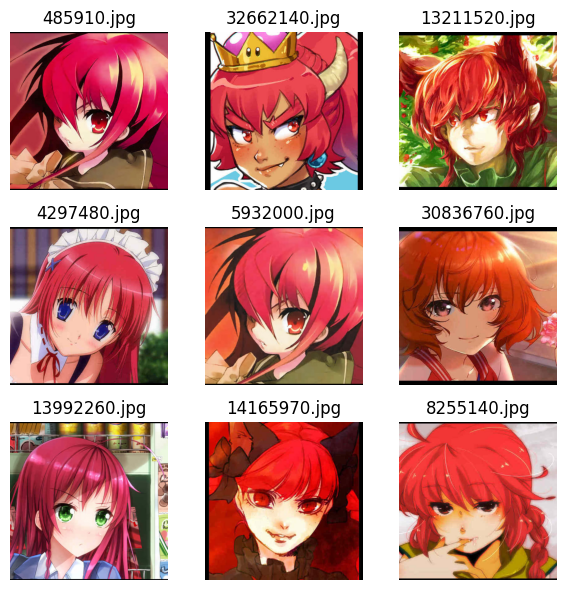

In [14]:
query_path = os.path.join(directory_path , "485910.jpg")
_,query= process_image_opencv(query_path)
if query.ndim == 1:
    query = query.reshape(1, -1)
query = query.astype('float32')
k_neighbors = 10  # Número de vecinos a recuperar
I, result = index.search(query, k_neighbors) 
results = process_results(result.flatten() , inverted_dict)
display_images_in_grid(results,3,3)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity


In [16]:
cos = cosine_similarity(feature_vector[result[0]], query)
cos.mean()

np.float64(0.8755143263179777)